Epoch #1


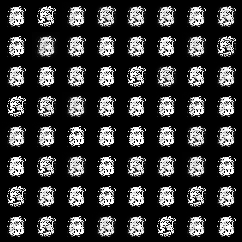



Epoch #2


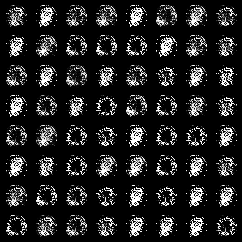



Epoch #3


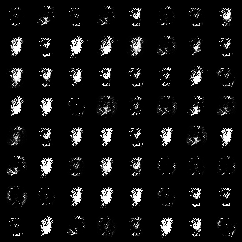



Epoch #4


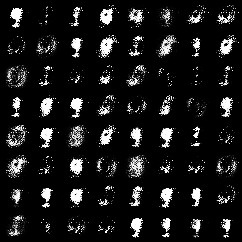



Epoch #5


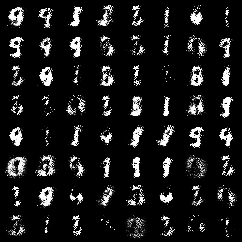



Epoch #6


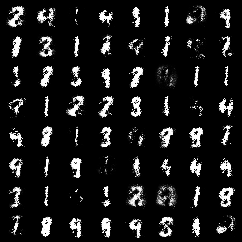



Epoch #7


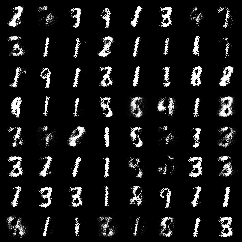



Epoch #8


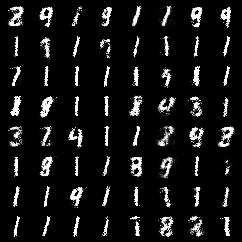



Epoch #9


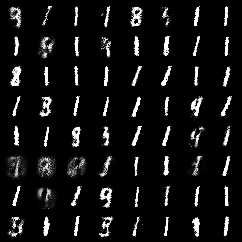



Epoch #10


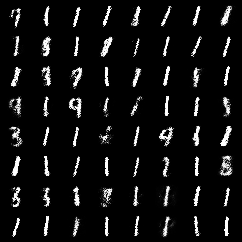



Epoch #11


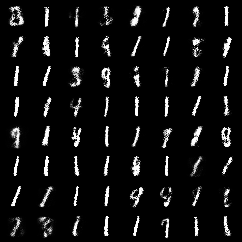



Epoch #12


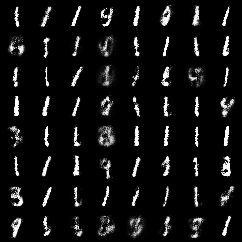



Epoch #13


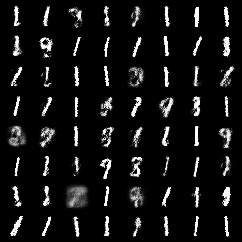



Epoch #14


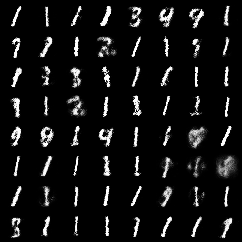



Epoch #15


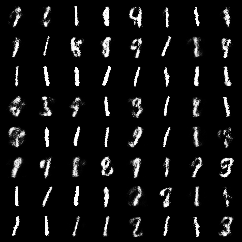



Epoch #16


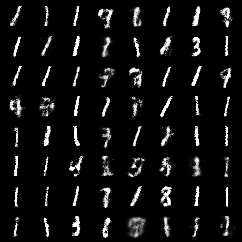



Epoch #17


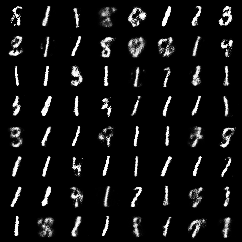



Epoch #18


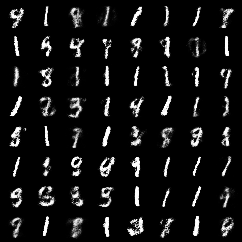



Epoch #19


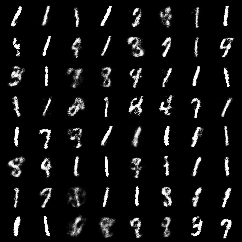



Epoch #20


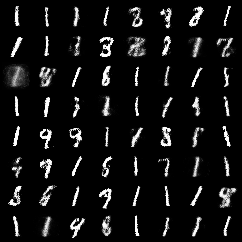



Epoch #21


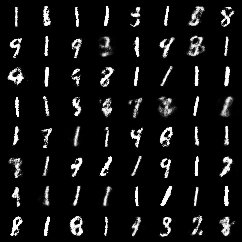



Epoch #22


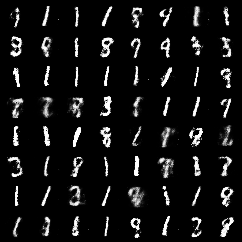



Epoch #23


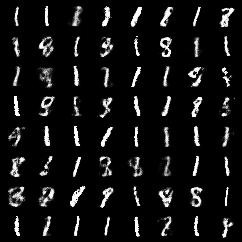



Epoch #24


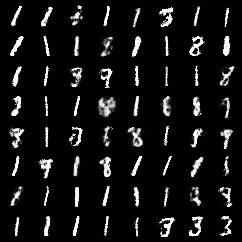



Epoch #25


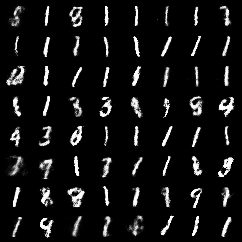



Epoch #26


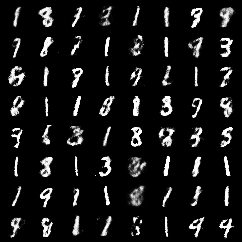



Epoch #27


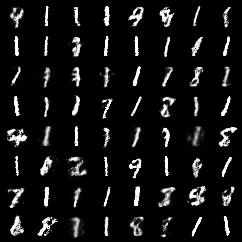



Epoch #28


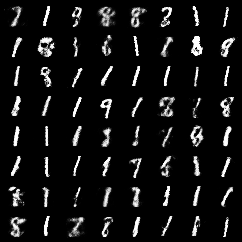



Epoch #29


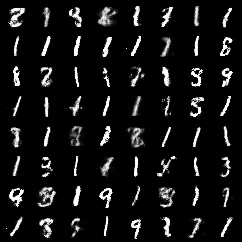



Epoch #30


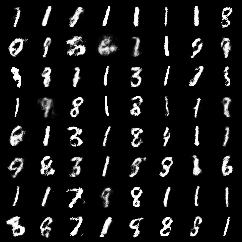



Epoch #31


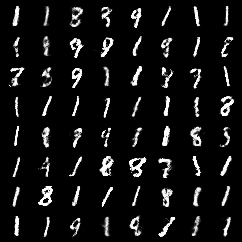



Epoch #32


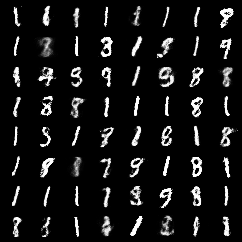



Epoch #33


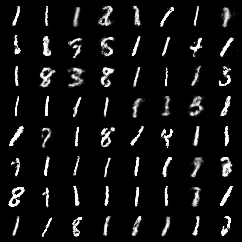



Epoch #34


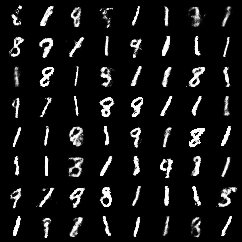



Epoch #35


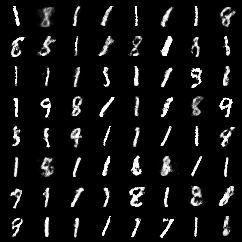



Epoch #36


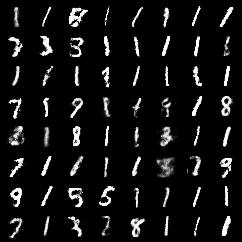



Epoch #37


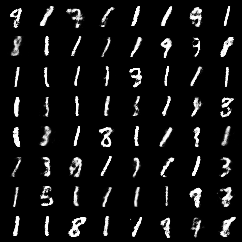



Epoch #38


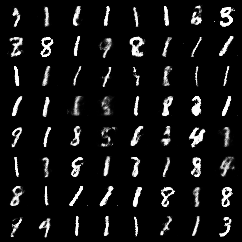



Epoch #39


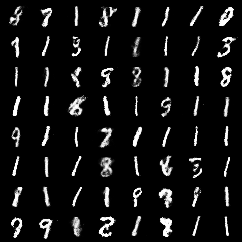



Epoch #40


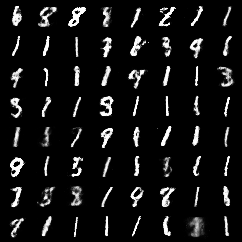



Epoch #41


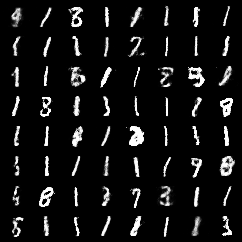



Epoch #42


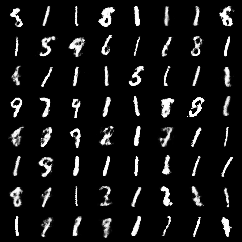



Epoch #43


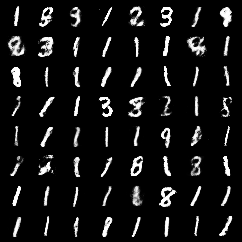



Epoch #44


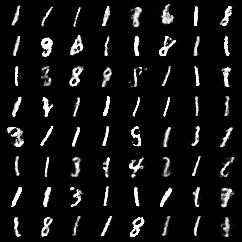



Epoch #45


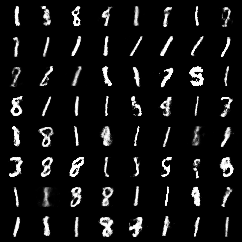



Epoch #46


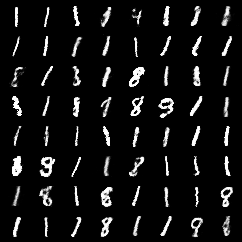



Epoch #47


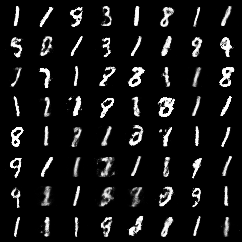



Epoch #48


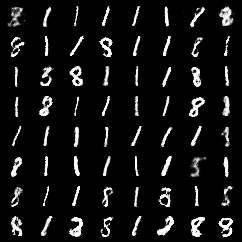



Epoch #49


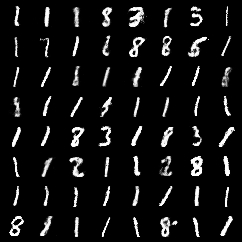



Epoch #50


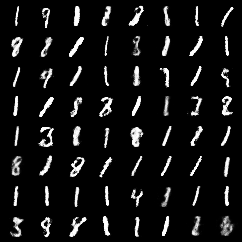

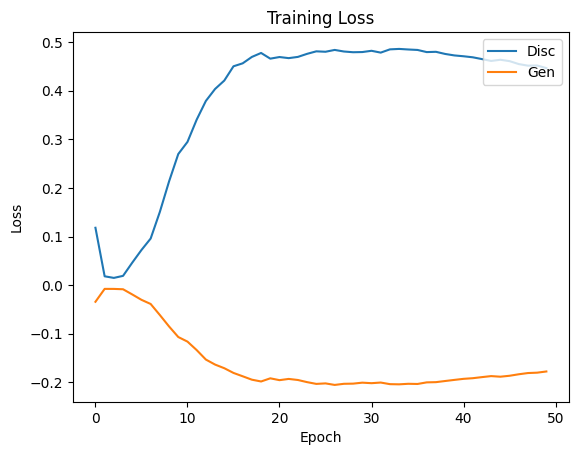

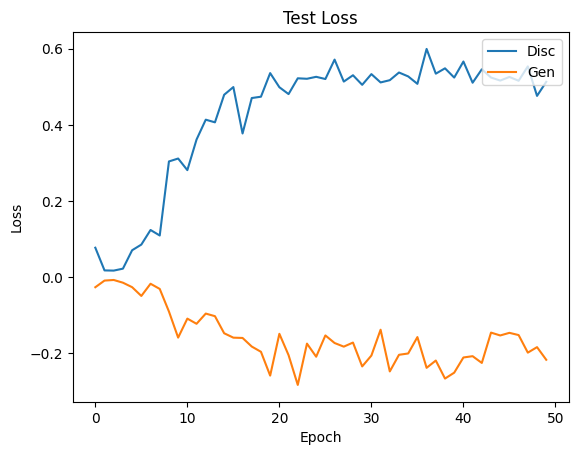

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt
import os

if not os.path.exists('results'):
    os.mkdir('results')

batch_size = 100
latent_size = 20

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
# load image data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)


class Generator(nn.Module):
    # GAN generator
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_size, 400)
        self.fc2 = nn.Linear(400, 784)

    def forward(self, z):
        # forward pass, returns output
        h = torch.relu(self.fc1(z))
        x = torch.sigmoid(self.fc2(h))
        return x

class Discriminator(nn.Module):
    # GAN discriminator
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 1)

    def forward(self, x):
        # forward pass, returns output
        h = torch.relu(self.fc1(x))
        out = torch.sigmoid(self.fc2(h))
        return out


def train(generator, generator_optimizer, discriminator, discriminator_optimizer):
    #Trains both the generator and discriminator for one epoch on the training dataset.
    #Returns the average generator and discriminator loss
    generator.train()
    discriminator.train()
    criterion = nn.BCELoss()

    total_generator_loss = 0.0
    total_discriminator_loss = 0.0

    for data, _ in train_loader:
        real_images = data.view(data.size(0), -1).to(device)
        batch_size_curr = real_images.size(0)

        real_labels = torch.ones(batch_size_curr, 1, device=device)
        fake_labels = torch.zeros(batch_size_curr, 1, device=device)

        # train discriminator
        discriminator_optimizer.zero_grad()

        # real images
        outputs_real = discriminator(real_images)
        d_loss_real = criterion(outputs_real, real_labels)

        # fake images
        z = torch.randn(batch_size_curr, latent_size, device=device)
        fake_images = generator(z)
        outputs_fake = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs_fake, fake_labels)
        g_loss = - d_loss_fake

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        discriminator_optimizer.step()

        # train generator
        generator_optimizer.zero_grad()
        z = torch.randn(batch_size_curr, latent_size, device=device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        # use this form to prevent vanishing gradients
        g_objective = criterion(outputs, real_labels)

        g_objective.backward()
        generator_optimizer.step()

        total_discriminator_loss += d_loss.item()
        total_generator_loss += g_loss.item()

    avg_generator_loss = total_generator_loss / len(train_loader)
    avg_discriminator_loss = total_discriminator_loss / len(train_loader)
    return avg_generator_loss, avg_discriminator_loss

def test(generator, discriminator):
    #Runs both the generator and discriminator over the test dataset.
    #Returns the average generator and discriminator loss
    generator.eval()
    discriminator.eval()
    criterion = nn.BCELoss()

    total_generator_loss = 0.0
    total_discriminator_loss = 0.0

    with torch.no_grad():
        for data, _ in test_loader:
            real_images = data.view(data.size(0), -1).to(device)
            batch_size_curr = real_images.size(0)

            real_labels = torch.ones(batch_size_curr, 1, device=device)
            fake_labels = torch.zeros(batch_size_curr, 1, device=device)

            # discriminator loss
            outputs_real = discriminator(real_images)
            d_loss_real = criterion(outputs_real, real_labels)

            z = torch.randn(batch_size_curr, latent_size, device=device)
            fake_images = generator(z)
            outputs_fake = discriminator(fake_images)
            d_loss_fake = criterion(outputs_fake, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            total_discriminator_loss += d_loss.item()

            # generator loss
            g_loss = - d_loss_fake
            total_generator_loss += g_loss.item()

    avg_generator_loss = total_generator_loss / len(test_loader)
    avg_discriminator_loss = total_discriminator_loss / len(test_loader)
    return avg_generator_loss, avg_discriminator_loss


epochs = 50

discriminator_avg_train_losses = []
discriminator_avg_test_losses = []
generator_avg_train_losses = []
generator_avg_test_losses = []

generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator_optimizer = optim.Adam(generator.parameters(), lr=1e-3)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-3)

for epoch in range(1, epochs + 1):
    generator_avg_train_loss, discriminator_avg_train_loss = train(generator, generator_optimizer, discriminator, discriminator_optimizer)
    generator_avg_test_loss, discriminator_avg_test_loss = test(generator, discriminator)

    discriminator_avg_train_losses.append(discriminator_avg_train_loss)
    generator_avg_train_losses.append(generator_avg_train_loss)
    discriminator_avg_test_losses.append(discriminator_avg_test_loss)
    generator_avg_test_losses.append(generator_avg_test_loss)

    with torch.no_grad():
        sample = torch.randn(64, latent_size).to(device)
        sample = generator(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Epoch #' + str(epoch))
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

plt.plot(discriminator_avg_train_losses)
plt.plot(generator_avg_train_losses)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Disc','Gen'], loc='upper right')
plt.show()

plt.plot(discriminator_avg_test_losses)
plt.plot(generator_avg_test_losses)
plt.title('Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Disc','Gen'], loc='upper right')
plt.show()
